IBL Neural Data Analysis: Spike Matrix and Raster Plots<br>
==============================================<br>
<br>
This notebook demonstrates how to:<br>
1. Load neural data from the International Brain Laboratory (IBL) dataset<br>
2. Create a cells Ã— time matrix of spike counts<br>
3. Generate raster plots to visualize neural activity

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from one.api import ONE
from brainbox.io.one import SpikeSortingLoader, EphysSessionLoader
from iblutil.numerical import bincount2D
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap

Connect to ONE

In [2]:
print("Connecting to ONE API...")
one = ONE(base_url='https://openalyx.internationalbrainlab.org')

Connecting to ONE API...


Define parameters

In [3]:
time_bin_size = 1  # 1s bins for spike count matrix
# time_bin_size = 0.05  # 50 ms bins for spike count matrix
depth_bin_size = 10   # 10 Âµm bins for depth raster

%% [markdown]<br>
## Part 1: Load data from a single probe insertion

Create a SpikeSortingLoader for a specific probe insertion<br>
This example uses a specific pid, but you can search for others

In [4]:
pids = ['da8dfec1-d265-44e8-84ce-6ae9c109b8bd', '6638cfb3-3831-4fc2-9327-194b76cf22e1']  # Example from documentation
print(f"Loading data for probe insertion: {pids}")

Loading data for probe insertion: ['da8dfec1-d265-44e8-84ce-6ae9c109b8bd', '6638cfb3-3831-4fc2-9327-194b76cf22e1']


Load spike sorting data

In [5]:
cluster_array = []
spikes_array = []
channels_array = []
for pid in pids:    
    ssl = SpikeSortingLoader(pid=pid, one=one)
    spikes, clusters, channels = ssl.load_spike_sorting()
    spikes_array.append(spikes)
    channels_array.append(channels)
    clusters = ssl.merge_clusters(spikes, clusters, channels)
    cluster_array.append(clusters)

In [6]:
for index in range(0, len(pids)):
    print(f"Loaded {len(spikes_array[index]['times'])} spikes and {len(np.unique(spikes_array[index]['clusters']))} clusters")
    good_clusters_idx = cluster_array[index]['label'] == 1
    
    good_cluster_ids = cluster_array[index]['cluster_id'][good_clusters_idx]

Loaded 39835238 spikes and 1143 clusters
Loaded 40880660 spikes and 1173 clusters


Loading data for 2 probe insertions
Loading data for probe 1/2: da8dfec1-d265-44e8-84ce-6ae9c109b8bd


Loading data for probe 2/2: 6638cfb3-3831-4fc2-9327-194b76cf22e1

Summary of loaded probe data:

Probe 1: probe00 (PID: da8dfec1-d265-44e8-84ce-6ae9c109b8bd)
  Session ID: 4ecb5d24-f5cc-402c-be28-9d0f7cb14b3a
  Total spikes: 39,835,238
  Total clusters: 1,143
  Good clusters (neurons): 298
  Recording duration: 4295.95 seconds
  Brain regions: 9 unique regions
  Top regions by neuron count:
    - LSr: 159 neurons
    - LPO: 37 neurons
    - LSv: 31 neurons
    - PS: 26 neurons
    - NDB: 22 neurons

Probe 2: probe01 (PID: 6638cfb3-3831-4fc2-9327-194b76cf22e1)
  Session ID: 4ecb5d24-f5cc-402c-be28-9d0f7cb14b3a
  Total spikes: 40,880,660
  Total clusters: 1,173
  Good clusters (neurons): 150
  Recording duration: 4295.95 seconds
  Brain regions: 3 unique regions
  Top regions by neuron count:
    - MOB: 125 neurons
    - FRP2/3: 23 neurons
    - MOs1: 2 neurons

Created spike matrix for probe00 with shape: (298, 85920)

Created spike matrix for probe01 with shape: (150, 85920)


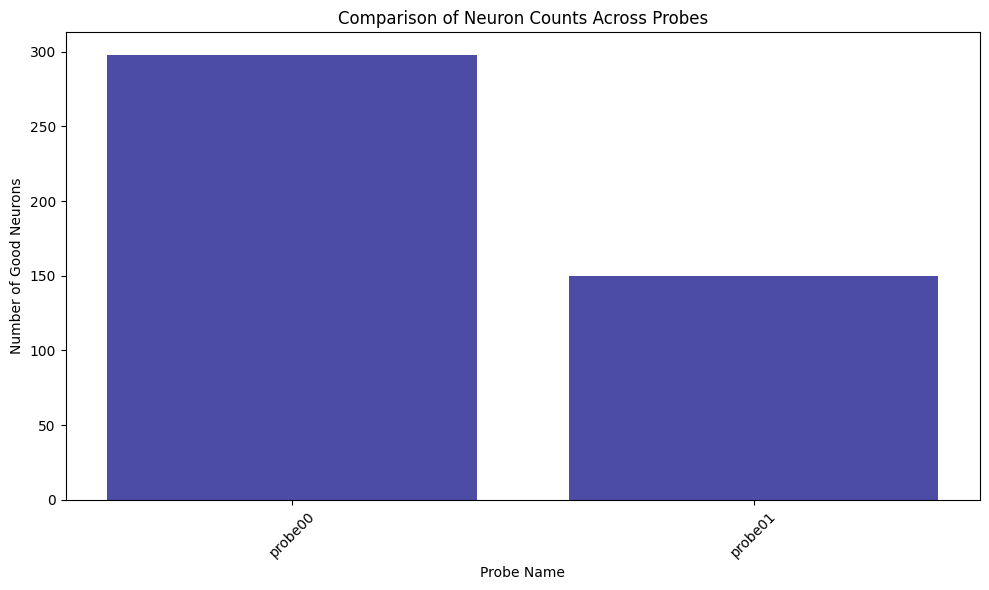

In [7]:
from collections import defaultdict
pids = [
    'da8dfec1-d265-44e8-84ce-6ae9c109b8bd',
    '6638cfb3-3831-4fc2-9327-194b76cf22e1'
]
print(f"Loading data for {len(pids)} probe insertions")

# Create a structured data container for all probe data
probe_data = {}

# Load data for each probe insertion
for i, pid in enumerate(pids):
    print(f"Loading data for probe {i+1}/{len(pids)}: {pid}")
    
    # Get probe and session information
    eid, pname = one.pid2eid(pid)
    
    # Create a container for this probe's data
    probe_data[pid] = {
        'pid': pid,
        'eid': eid,
        'pname': pname,
        'metadata': {}
    }
    
    # Load spike sorting data
    ssl = SpikeSortingLoader(pid=pid, one=one)
    spikes, clusters, channels = ssl.load_spike_sorting()
    
    # Store raw data
    probe_data[pid]['spikes'] = spikes
    probe_data[pid]['channels'] = channels
    
    # Merge cluster data with brain region info
    clusters = ssl.merge_clusters(spikes, clusters, channels)
    probe_data[pid]['clusters'] = clusters
    
    # Store basic metadata
    probe_data[pid]['metadata']['n_spikes'] = len(spikes['times'])
    probe_data[pid]['metadata']['n_clusters'] = len(np.unique(spikes['clusters']))
    
    # Filter for good quality units (neurons)
    good_clusters_idx = clusters['label'] == 1
    good_cluster_ids = clusters['cluster_id'][good_clusters_idx]
    probe_data[pid]['good_cluster_ids'] = good_cluster_ids
    probe_data[pid]['metadata']['n_good_clusters'] = len(good_cluster_ids)
    
    # Get time range of recording
    probe_data[pid]['metadata']['t_start'] = np.min(spikes['times'])
    probe_data[pid]['metadata']['t_end'] = np.max(spikes['times'])
    probe_data[pid]['metadata']['duration'] = probe_data[pid]['metadata']['t_end'] - probe_data[pid]['metadata']['t_start']
    
    # Get brain regions if available
    if 'acronym' in clusters:
        regions = np.unique(clusters['acronym'][good_clusters_idx])
        probe_data[pid]['metadata']['brain_regions'] = regions
        
        # Count neurons per region
        region_counts = defaultdict(int)
        for j in np.where(good_clusters_idx)[0]:
            region = clusters['acronym'][j]
            region_counts[region] += 1
        probe_data[pid]['metadata']['neurons_per_region'] = dict(region_counts)

# Print summary information for all probes
print("\nSummary of loaded probe data:")
for i, (pid, data) in enumerate(probe_data.items()):
    meta = data['metadata']
    print(f"\nProbe {i+1}: {data['pname']} (PID: {pid})")
    print(f"  Session ID: {data['eid']}")
    print(f"  Total spikes: {meta['n_spikes']:,}")
    print(f"  Total clusters: {meta['n_clusters']:,}")
    print(f"  Good clusters (neurons): {meta['n_good_clusters']:,}")
    print(f"  Recording duration: {meta['duration']:.2f} seconds")
    
    if 'brain_regions' in meta:
        print(f"  Brain regions: {len(meta['brain_regions'])} unique regions")
        # Print top 5 regions by neuron count
        sorted_regions = sorted(meta['neurons_per_region'].items(), key=lambda x: x[1], reverse=True)
        print(f"  Top regions by neuron count:")
        for region, count in sorted_regions[:5]:
            print(f"    - {region}: {count} neurons")

# Create a figure comparing the number of neurons across probes
plt.figure(figsize=(10, 6))
probe_names = [data['pname'] for data in probe_data.values()]
neuron_counts = [data['metadata']['n_good_clusters'] for data in probe_data.values()]

plt.bar(range(len(probe_names)), neuron_counts, color='navy', alpha=0.7)
plt.xticks(range(len(probe_names)), probe_names, rotation=45)
plt.xlabel('Probe Name')
plt.ylabel('Number of Good Neurons')
plt.title('Comparison of Neuron Counts Across Probes')
plt.tight_layout()

# Function to create spike count matrices for any probe
def create_spike_matrix(pid, bin_size=0.05):
    """
    Create a spike count matrix for a specific probe
    
    Parameters:
    - pid: Probe insertion ID
    - bin_size: Time bin size in seconds
    
    Returns:
    - spike_matrix: Matrix where rows are neurons and columns are time bins
    - time_bins: Array of time bin edges
    """
    data = probe_data[pid]
    spikes = data['spikes']
    good_cluster_ids = data['good_cluster_ids']
    
    # Set up time bins
    t_start = data['metadata']['t_start']
    t_end = data['metadata']['t_end']
    time_bins = np.arange(t_start, t_end + bin_size, bin_size)
    n_time_bins = len(time_bins) - 1
    
    # Initialize the spike count matrix
    n_neurons = len(good_cluster_ids)
    spike_matrix = np.zeros((n_neurons, n_time_bins))
    
    # Fill the matrix
    for i, cluster_id in enumerate(good_cluster_ids):
        # Get spike times for this cluster
        cluster_spike_times = spikes['times'][spikes['clusters'] == cluster_id]
        
        # Bin the spike times
        spike_counts, _ = np.histogram(cluster_spike_times, bins=time_bins)
        
        # Add to matrix
        spike_matrix[i, :] = spike_counts
    
    return spike_matrix, time_bins

# Create spike matrices for all probes
for pid in probe_data:
    spike_matrix, time_bins = create_spike_matrix(pid)
    probe_data[pid]['spike_matrix'] = spike_matrix
    probe_data[pid]['time_bins'] = time_bins
    print(f"\nCreated spike matrix for {probe_data[pid]['pname']} with shape: {spike_matrix.shape}")

%% [markdown]<br>
## Part 2: Filter for good quality units (clusters)

Find the clusters labeled as "good" (label == 1)

In [7]:
good_clusters_idx = clusters['label'] == 1
good_cluster_ids = clusters['cluster_id'][good_clusters_idx]

In [8]:
print(f"Number of good clusters: {len(good_cluster_ids)} out of {len(clusters['cluster_id'])}")

Number of good clusters: 298 out of 1143


Get basic statistics about these clusters

In [9]:
if 'firing_rate' in clusters:
    mean_fr = np.mean(clusters['firing_rate'][good_clusters_idx])
    min_fr = np.min(clusters['firing_rate'][good_clusters_idx])
    max_fr = np.max(clusters['firing_rate'][good_clusters_idx])
    print(f"Firing rate statistics for good clusters:")
    print(f"  Mean: {mean_fr:.2f} Hz")
    print(f"  Min: {min_fr:.2f} Hz")
    print(f"  Max: {max_fr:.2f} Hz")

Firing rate statistics for good clusters:
  Mean: 10.71 Hz
  Min: 0.33 Hz
  Max: 78.65 Hz


%% [markdown]<br>
## Part 3: Create a spike count matrix (cells Ã— time)

Set up time bins for the recording

In [10]:
t_start = np.min(spikes['times'])
t_end = np.max(spikes['times'])
time_bins = np.arange(t_start, t_end + time_bin_size, time_bin_size)
n_time_bins = len(time_bins) - 1

In [11]:
print(f"Time range: {t_start:.2f}s to {t_end:.2f}s")
print(f"Number of time bins: {n_time_bins}")

Time range: 0.00s to 4295.95s
Number of time bins: 4296


Initialize the spike count matrix (rows = cells, columns = time bins)

In [12]:
n_cells = len(good_cluster_ids)
spike_matrix = np.zeros((n_cells, n_time_bins))

For each good cluster, bin its spikes into the time bins

In [13]:
print("Creating spike count matrix...")
for i, cluster_id in enumerate(good_cluster_ids):
    # Get spike times for this cluster
    cluster_spike_times = spikes['times'][spikes['clusters'] == cluster_id]
    
    # Bin the spike times
    spike_counts, _ = np.histogram(cluster_spike_times, bins=time_bins)
    
    # Add to matrix
    spike_matrix[i, :] = spike_counts

Creating spike count matrix...


In [14]:
print(f"Created spike matrix with shape: {spike_matrix.shape}")

Created spike matrix with shape: (298, 4296)


Convert to firing rates (spikes/second)

In [15]:
firing_rate_matrix = spike_matrix / time_bin_size

%% [markdown]<br>
## Part 4: Visualize the spike count matrix

Create a figure to visualize a portion of the spike matrix

In [16]:
plt.figure(figsize=(14, 8), dpi=200)
# Only show a subset if the matrix is very large
max_time_bins_to_show = min(500, n_time_bins)
max_cells_to_show = min(100, n_cells)

<Figure size 2800x1600 with 0 Axes>

Create a custom colormap from white to black

In [17]:
cmap = LinearSegmentedColormap.from_list('custom_cmap', ['white', 'black'])

Plot the spike matrix

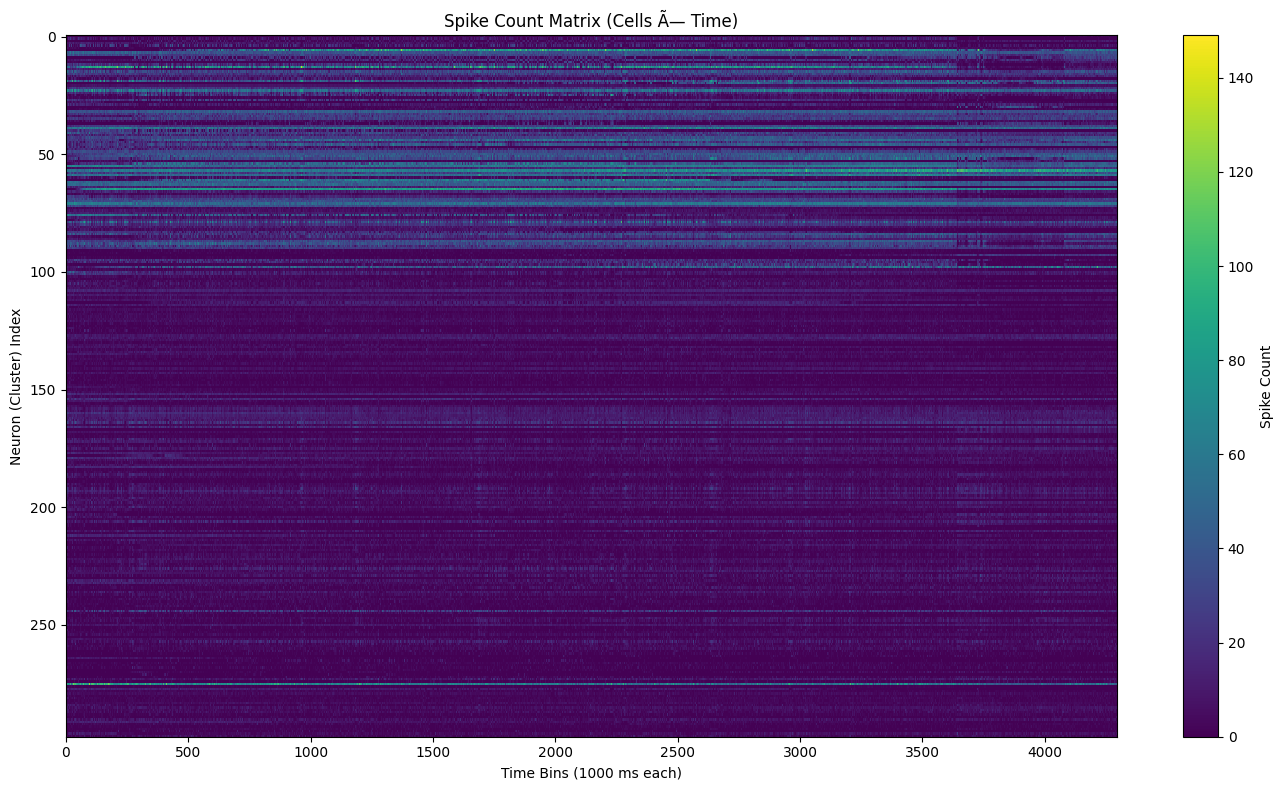

In [18]:
plt.figure(figsize=(14, 8), dpi=100)
# Only show a subset if the matrix is very large
max_time_bins_to_show = min(500000, n_time_bins)
max_cells_to_show = min(10000, n_cells)
cmap = LinearSegmentedColormap.from_list('custom_cmap', ['white', 'black'])
plt.imshow(spike_matrix[:max_cells_to_show, :max_time_bins_to_show], 
           aspect='auto', 
           cmap='viridis',
           interpolation='none')

plt.colorbar(label='Spike Count')
plt.xlabel(f'Time Bins ({time_bin_size*1000:.0f} ms each)')
plt.ylabel('Neuron (Cluster) Index')
plt.title('Spike Count Matrix (Cells Ã— Time)')
plt.tight_layout()

Spike count statistics for 298 neurons:
  Total spikes: 13705503
  Mean spikes per neuron: 45991.62
  Median spikes per neuron: 21755.50
  Min spikes: 1436
  Max spikes: 337859
Firing rate statistics (Hz):
  Mean firing rate: 10.71
  Median firing rate: 5.06
  Min firing rate: 0.33
  Max firing rate: 78.65


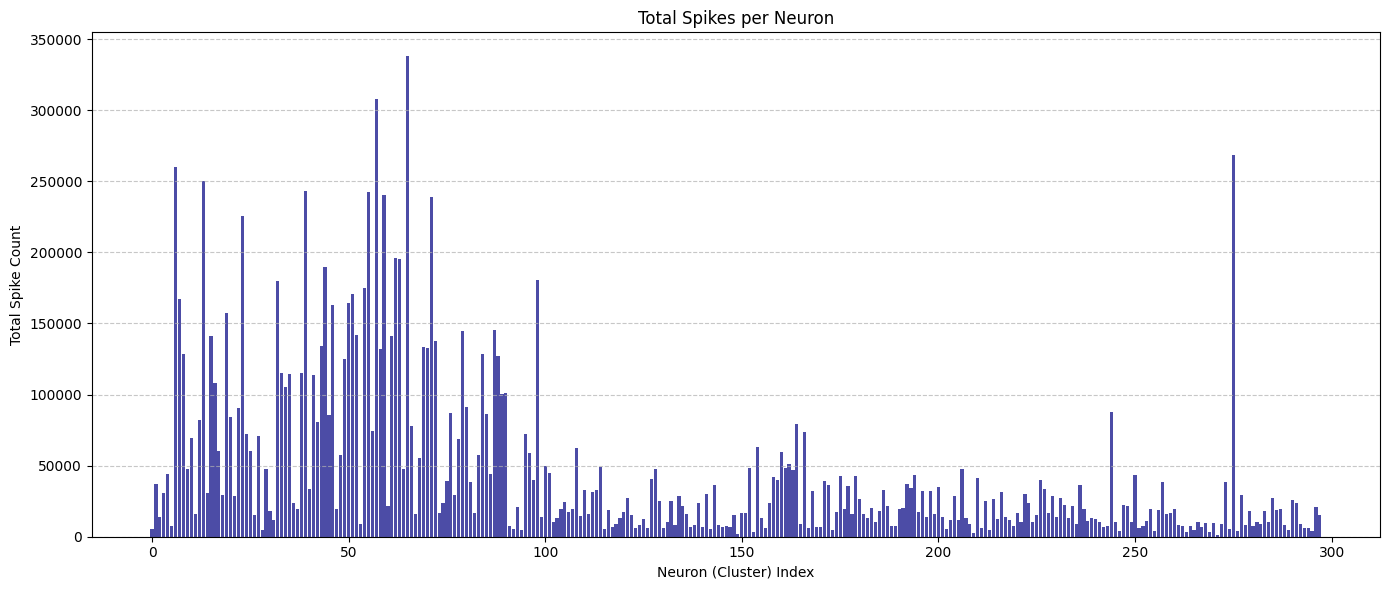

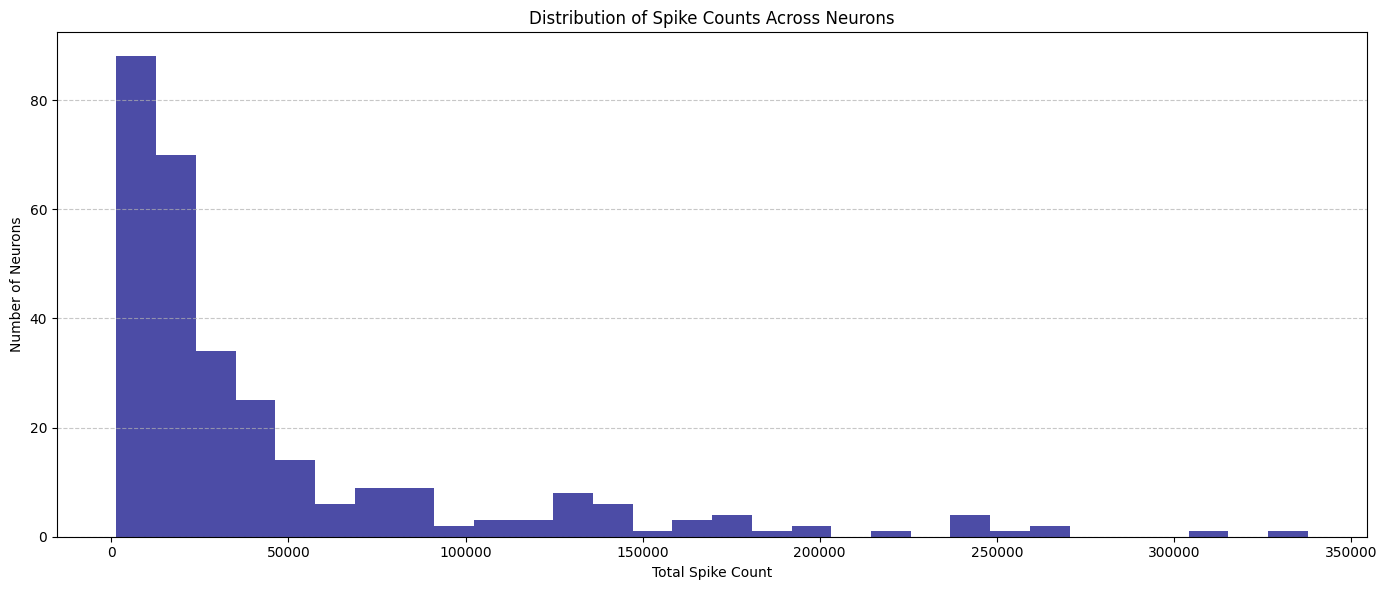

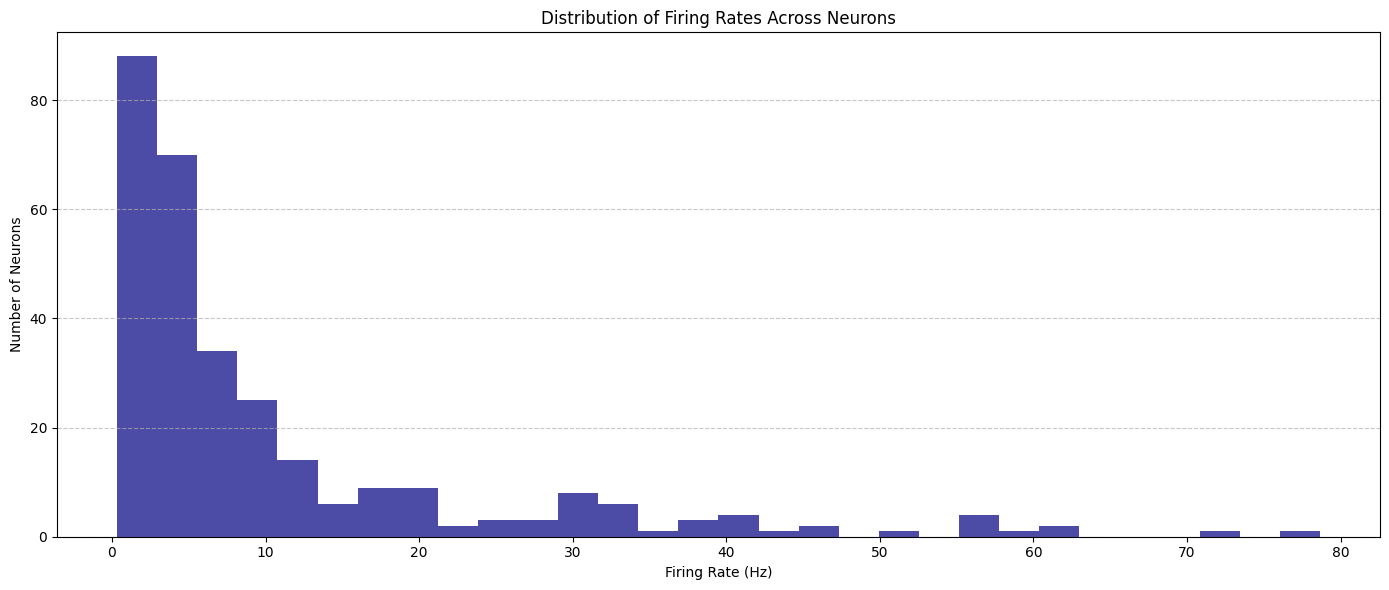

In [19]:
# %% [markdown]
# ## Part 4b: Analyze spike distribution across neurons

# Calculate the total number of spikes for each neuron
total_spikes_per_neuron = np.sum(spike_matrix, axis=1)

# Create a bar plot
plt.figure(figsize=(14, 6))
plt.bar(range(len(total_spikes_per_neuron)), total_spikes_per_neuron, color='navy', alpha=0.7)
plt.xlabel('Neuron (Cluster) Index')
plt.ylabel('Total Spike Count')
plt.title('Total Spikes per Neuron')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Display some summary statistics
total_session_spikes = np.sum(total_spikes_per_neuron)
mean_spikes_per_neuron = np.mean(total_spikes_per_neuron)
median_spikes_per_neuron = np.median(total_spikes_per_neuron)
min_spikes = np.min(total_spikes_per_neuron)
max_spikes = np.max(total_spikes_per_neuron)

print(f"Spike count statistics for {len(total_spikes_per_neuron)} neurons:")
print(f"  Total spikes: {total_session_spikes:.0f}")
print(f"  Mean spikes per neuron: {mean_spikes_per_neuron:.2f}")
print(f"  Median spikes per neuron: {median_spikes_per_neuron:.2f}")
print(f"  Min spikes: {min_spikes:.0f}")
print(f"  Max spikes: {max_spikes:.0f}")

# Create a histogram of spike counts per neuron
plt.figure(figsize=(14, 6))
plt.hist(total_spikes_per_neuron, bins=30, color='navy', alpha=0.7)
plt.xlabel('Total Spike Count')
plt.ylabel('Number of Neurons')
plt.title('Distribution of Spike Counts Across Neurons')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Calculate firing rates (spikes per second) for each neuron
recording_duration = t_end - t_start
firing_rates = total_spikes_per_neuron / recording_duration

# Create a histogram of firing rates
plt.figure(figsize=(14, 6))
plt.hist(firing_rates, bins=30, color='navy', alpha=0.7)
plt.xlabel('Firing Rate (Hz)')
plt.ylabel('Number of Neurons')
plt.title('Distribution of Firing Rates Across Neurons')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Display firing rate statistics
mean_firing_rate = np.mean(firing_rates)
median_firing_rate = np.median(firing_rates)
min_firing_rate = np.min(firing_rates)
max_firing_rate = np.max(firing_rates)

print(f"Firing rate statistics (Hz):")
print(f"  Mean firing rate: {mean_firing_rate:.2f}")
print(f"  Median firing rate: {median_firing_rate:.2f}")
print(f"  Min firing rate: {min_firing_rate:.2f}")
print(f"  Max firing rate: {max_firing_rate:.2f}")


<Axes: ylabel='Count'>

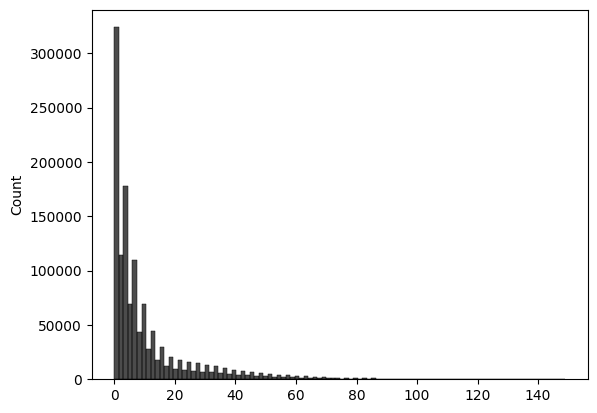

In [20]:
import seaborn as sns

sns.histplot(spike_matrix.flatten(), bins=100, color='black', alpha=0.7)
# spike_matrix

Performing PCA on spike count data...
Cumulative explained variance:
  PC1-PC1: 0.0646 (6.46%)
  PC1-PC2: 0.0911 (9.11%)
  PC1-PC3: 0.1168 (11.68%)
  PC1-PC4: 0.1376 (13.76%)
  PC1-PC5: 0.1546 (15.46%)
  PC1-PC6: 0.1691 (16.91%)
  PC1-PC7: 0.1817 (18.17%)
  PC1-PC8: 0.1929 (19.29%)
  PC1-PC9: 0.2034 (20.34%)
  PC1-PC10: 0.2131 (21.31%)


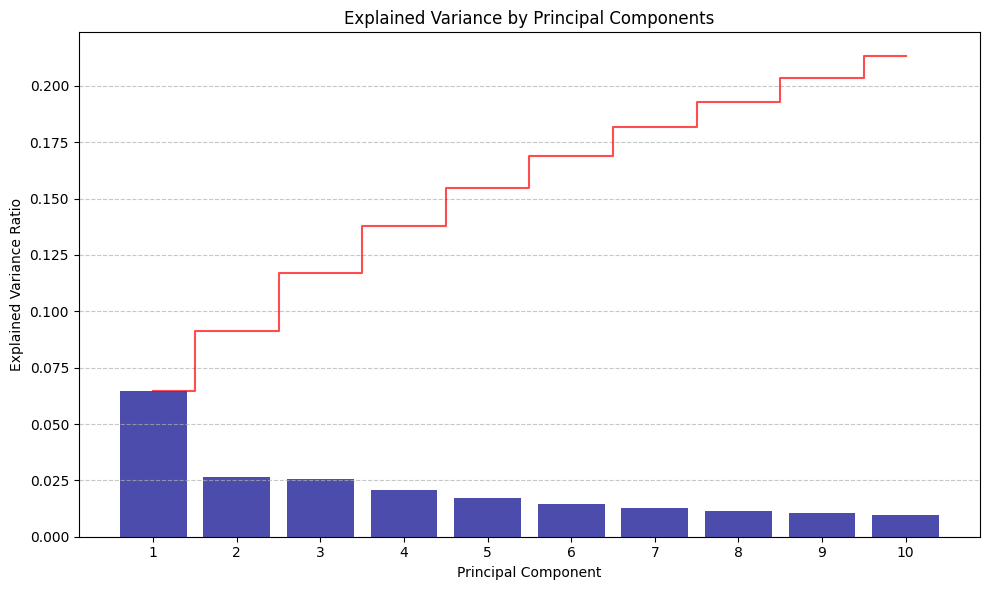

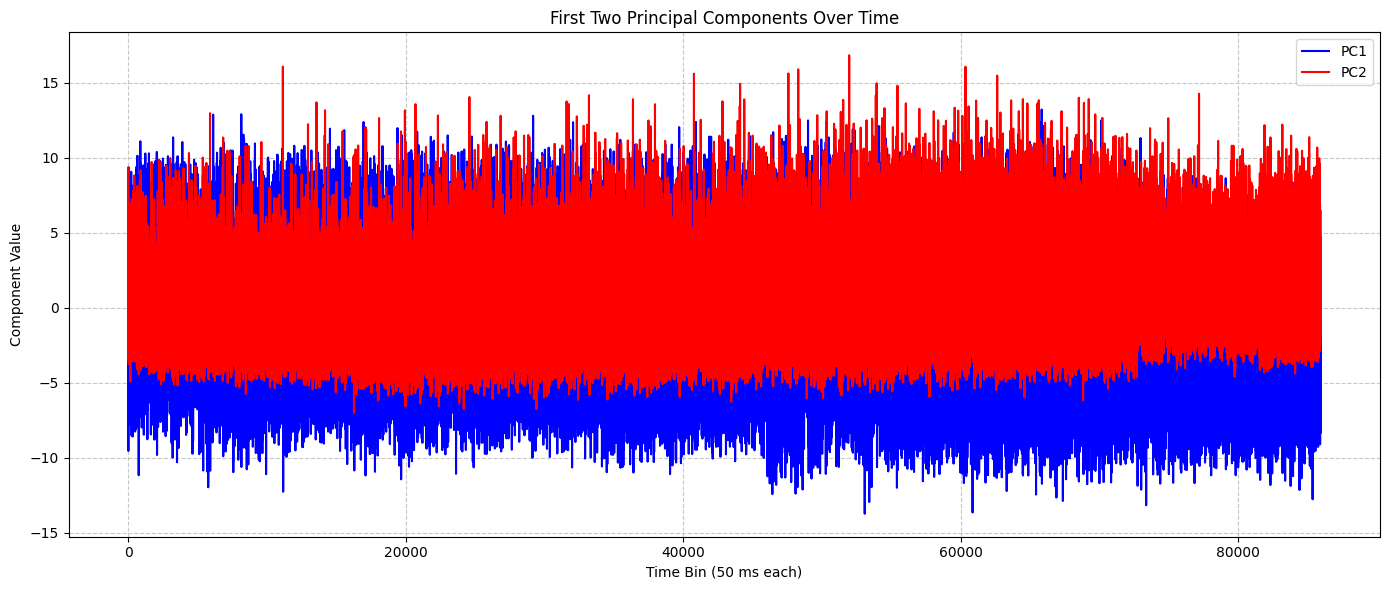

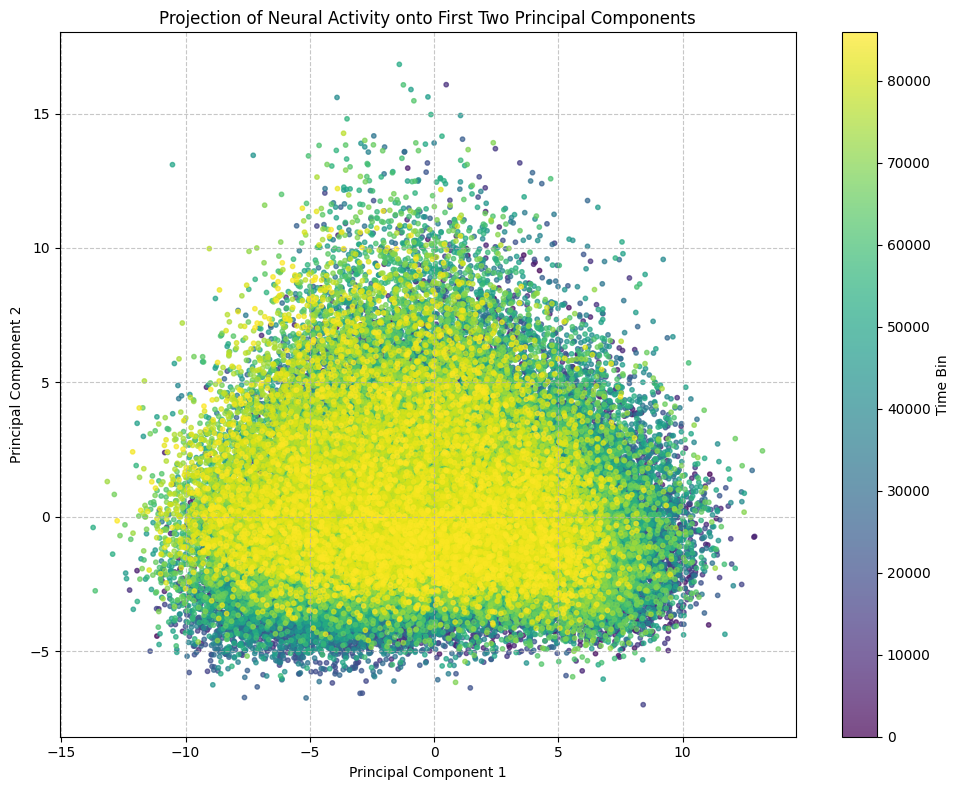

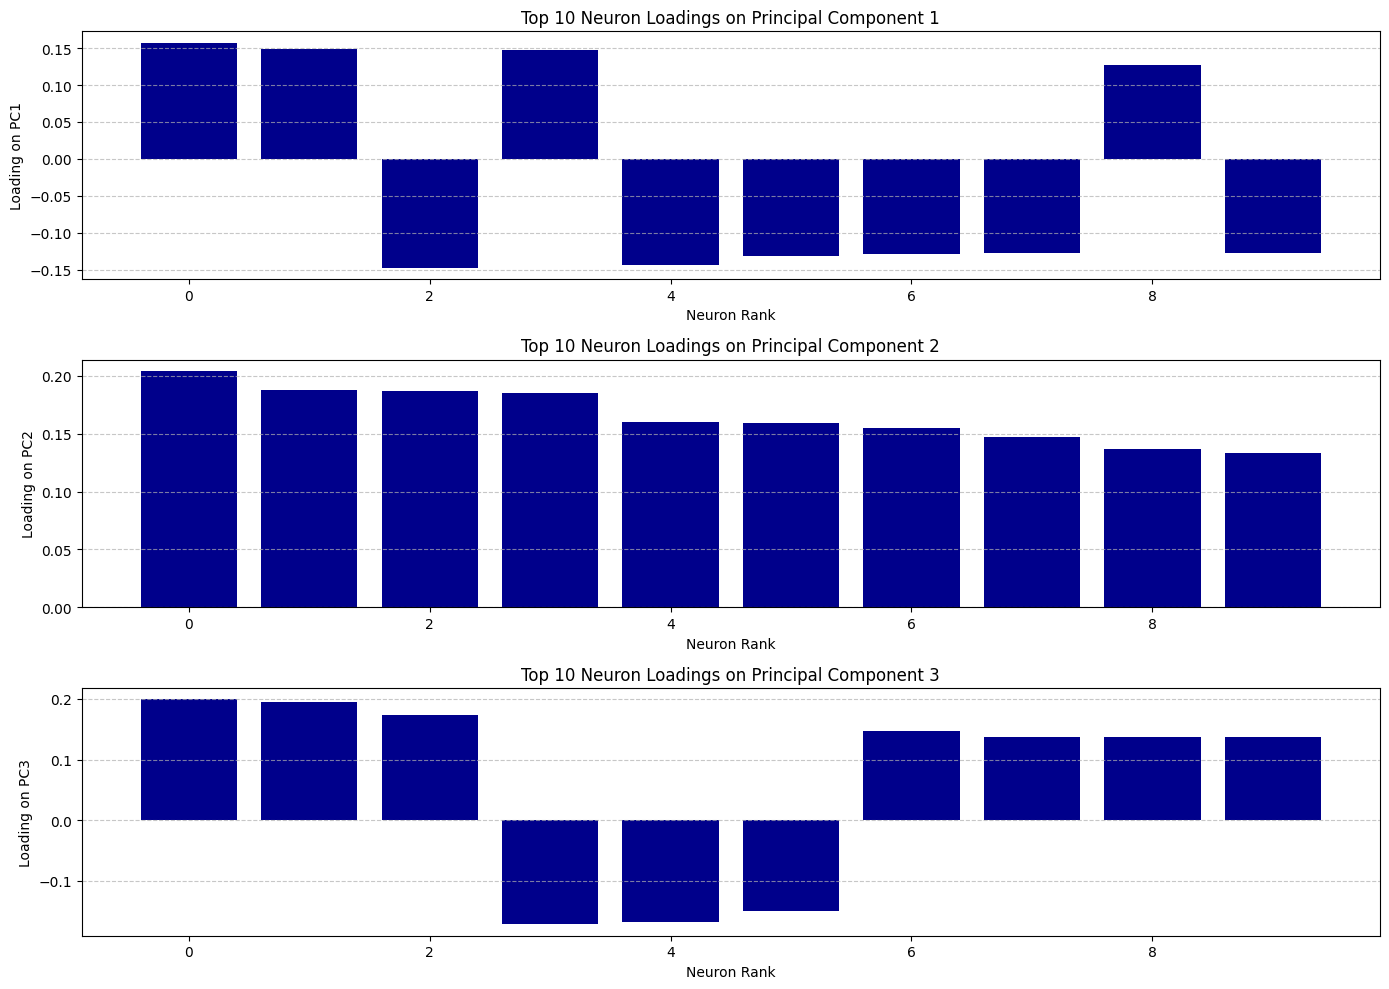

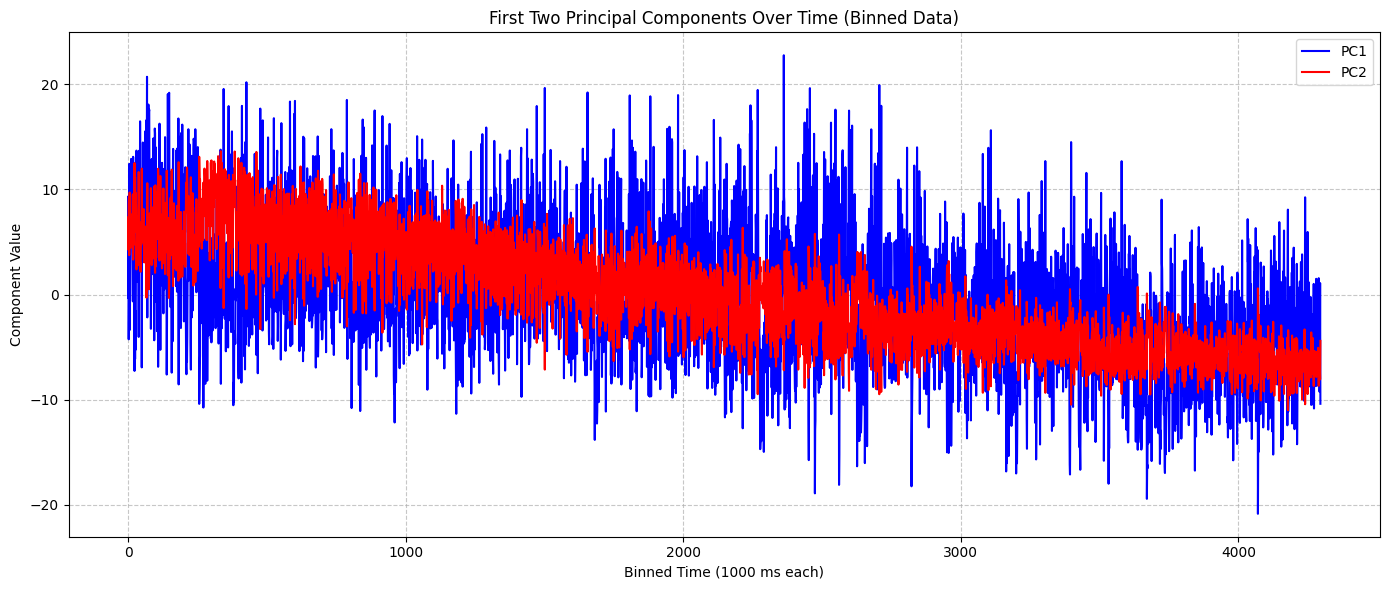

In [40]:

# %% [markdown]
# ## Part 4c: Principal Component Analysis (PCA) of neural data

# Perform PCA on the firing rate matrix (neurons x time)
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Option 1: PCA on the raw spike counts
print("Performing PCA on spike count data...")

# Z-score normalize each neuron's spike counts
# This is important because neurons with higher firing rates would otherwise dominate the PCA
scaler = StandardScaler()
spike_matrix_normalized = scaler.fit_transform(spike_matrix.T)  # Transpose to get time bins x neurons

# Apply PCA
n_components = min(10, min(spike_matrix_normalized.shape))  # Choose fewer components than dimensions
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(spike_matrix_normalized)

# Plot the explained variance ratio
plt.figure(figsize=(10, 6))
plt.bar(range(1, n_components + 1), pca.explained_variance_ratio_, alpha=0.7, color='darkblue')
plt.step(range(1, n_components + 1), np.cumsum(pca.explained_variance_ratio_), where='mid', 
         color='red', alpha=0.7)
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Component')
plt.title('Explained Variance by Principal Components')
plt.xticks(range(1, n_components + 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Calculate and print the cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
print("Cumulative explained variance:")
for i, var in enumerate(cumulative_variance):
    print(f"  PC1-PC{i+1}: {var:.4f} ({var*100:.2f}%)")

# Plot the first two principal components over time
plt.figure(figsize=(14, 6))
plt.plot(principal_components[:, 0], label='PC1', color='blue')
plt.plot(principal_components[:, 1], label='PC2', color='red')
plt.xlabel(f'Time Bin ({time_bin_size*1000:.0f} ms each)')
plt.ylabel('Component Value')
plt.title('First Two Principal Components Over Time')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Plot the projection of the data onto the first two principal components
plt.figure(figsize=(10, 8))
plt.scatter(principal_components[:, 0], principal_components[:, 1], 
            s=10, c=np.arange(len(principal_components)), cmap='viridis', alpha=0.7)
plt.colorbar(label='Time Bin')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Projection of Neural Activity onto First Two Principal Components')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Examine the loadings (weights) of each neuron on the first few PCs
pc_loadings = pca.components_
n_top_neurons = 10  # Number of top contributing neurons to examine

# Find the neurons with the highest absolute loadings for the first 3 PCs
plt.figure(figsize=(14, 10))
for i in range(min(3, n_components)):
    plt.subplot(3, 1, i+1)
    
    # Get the absolute loadings for this PC
    abs_loadings = np.abs(pc_loadings[i, :])
    
    # Find the indices of the top contributing neurons
    top_neuron_indices = np.argsort(abs_loadings)[-n_top_neurons:][::-1]
    
    # Plot the loadings for these neurons
    plt.bar(range(n_top_neurons), pc_loadings[i, top_neuron_indices], color='darkblue')
    plt.xlabel('Neuron Rank')
    plt.ylabel(f'Loading on PC{i+1}')
    plt.title(f'Top {n_top_neurons} Neuron Loadings on Principal Component {i+1}')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()

# Optional: Binned PCA for better temporal visualization
# This is useful for very long recordings to see trends more clearly
bin_factor = 20  # Combine this many time bins together
n_bins = spike_matrix.shape[1]
n_binned = n_bins // bin_factor

# Skip this if there aren't enough time bins
if n_binned > 10:
    # Create binned spike matrix by summing across adjacent time bins
    binned_spike_matrix = np.zeros((spike_matrix.shape[0], n_binned))
    for i in range(n_binned):
        start_idx = i * bin_factor
        end_idx = min((i + 1) * bin_factor, n_bins)
        binned_spike_matrix[:, i] = np.sum(spike_matrix[:, start_idx:end_idx], axis=1)
    
    # Normalize and run PCA on binned data
    binned_normalized = StandardScaler().fit_transform(binned_spike_matrix.T)
    binned_pca = PCA(n_components=min(10, binned_normalized.shape[1]))
    binned_pcs = binned_pca.fit_transform(binned_normalized)
    
    # Plot the first two PCs from binned data
    plt.figure(figsize=(14, 6))
    plt.plot(binned_pcs[:, 0], label='PC1', color='blue')
    plt.plot(binned_pcs[:, 1], label='PC2', color='red')
    plt.xlabel(f'Binned Time ({bin_factor * time_bin_size*1000:.0f} ms each)')
    plt.ylabel('Component Value')
    plt.title('First Two Principal Components Over Time (Binned Data)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()

%% [markdown]<br>
## Part 5: Create a depth raster plot (similar to the IBL visualization)

Creating depth raster plot...


Text(0.5, 1.0, 'Neural Activity Raster Plot\n39831728 spikes across all depths')

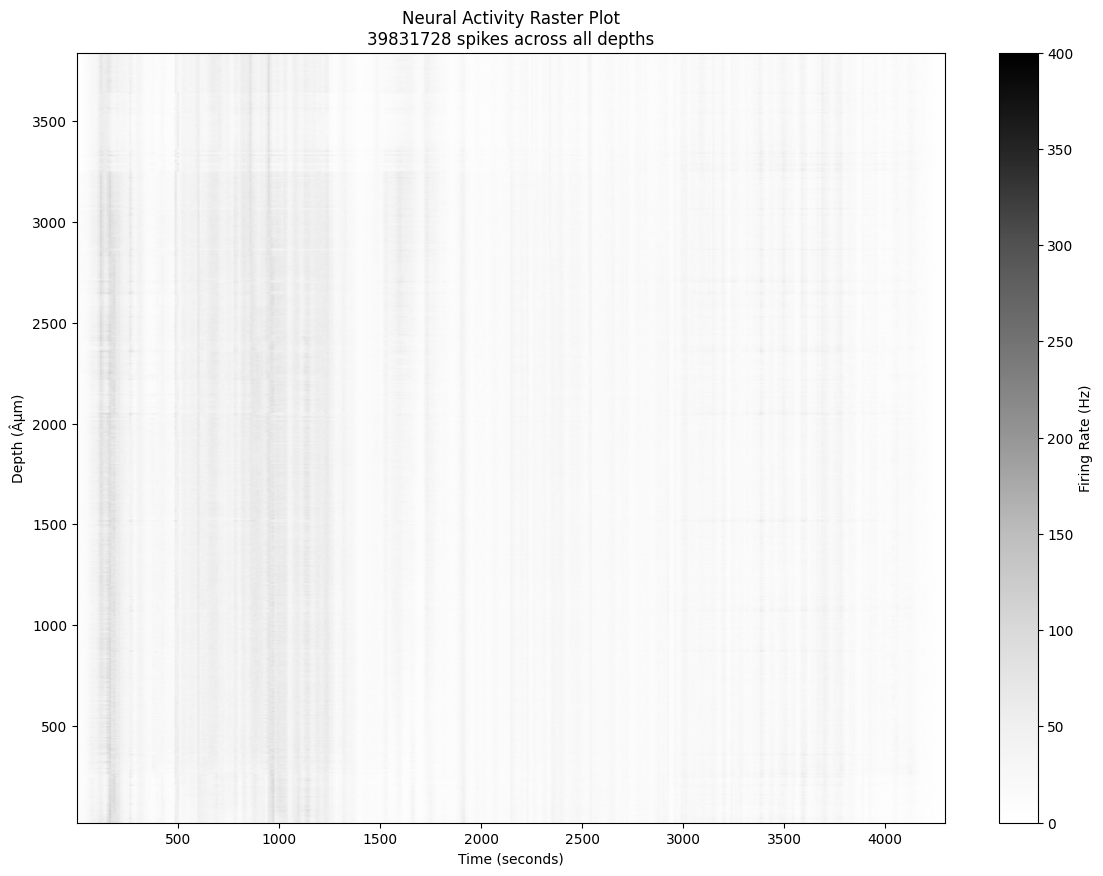

In [33]:
print("Creating depth raster plot...")
# Remove any NaN values
keep_idx = np.bitwise_and(~np.isnan(spikes['times']), ~np.isnan(spikes['depths']))
fr, time_edges, depth_edges = bincount2D(
    spikes['times'][keep_idx], 
    spikes['depths'][keep_idx], 
    time_bin_size, 
    depth_bin_size
)
fr = fr / time_bin_size
fig, ax = plt.subplots(figsize=(14, 10))
extent = [time_edges[0], time_edges[-1], depth_edges[0], depth_edges[-1]]

img = ax.imshow(fr.T, 
                aspect='auto', 
                origin='lower', 
                cmap='Greys',
                extent=extent)
plt.colorbar(img, ax=ax, label='Firing Rate (Hz)')
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Depth (Âµm)')
ax.set_title(f'Neural Activity Raster Plot\n{len(spikes["times"][keep_idx])} spikes across all depths')

%% [markdown]<br>
## Part 6: Use the built-in IBL raster plotting function

The IBL toolkit provides a built-in function for creating raster plots

In [ ]:
print("Creating IBL raster plot...")
fig, axs = ssl.raster(spikes, channels)

%% [markdown]<br>
## Part 7: Create raster plots for individual neurons

Select a few example neurons to visualize

In [ ]:
num_examples = min(4, len(good_cluster_ids))
example_indices = np.random.choice(len(good_cluster_ids), num_examples, replace=False)
example_cluster_ids = good_cluster_ids[example_indices]

Create a figure with subplots for each example neuron

In [ ]:
fig, axs = plt.subplots(num_examples, 1, figsize=(14, 3*num_examples), sharex=True)

In [ ]:
for i, cluster_id in enumerate(example_cluster_ids):
    # Get spike times for this cluster
    cluster_spike_times = spikes['times'][spikes['clusters'] == cluster_id]
    
    # Plot raster
    axs[i].eventplot(cluster_spike_times, lineoffsets=0.5, linelengths=1, linewidths=0.5, color='black')
    axs[i].set_ylabel(f'Cluster {cluster_id}')
    
    # Add text with cluster info
    idx = np.where(clusters['cluster_id'] == cluster_id)[0][0]
    if 'acronym' in clusters:
        region = clusters['acronym'][idx]
    else:
        region = 'Unknown'
    
    if 'firing_rate' in clusters:
        fr = clusters['firing_rate'][idx]
        axs[i].text(0.98, 0.95, f"Region: {region}, FR: {fr:.2f} Hz", 
                 transform=axs[i].transAxes, ha='right', va='top')
    else:
        axs[i].text(0.98, 0.95, f"Region: {region}", 
                 transform=axs[i].transAxes, ha='right', va='top')

In [ ]:
plt.xlabel('Time (seconds)')
plt.tight_layout()

%% [markdown]<br>
## Part 8: Load data from an entire session (multiple probes)

Get a session ID from the probe insertion

In [21]:
eid, pname = one.pid2eid(pid)
print(f"Loading data for session: {eid}")

Loading data for session: 4ecb5d24-f5cc-402c-be28-9d0f7cb14b3a


Use EphysSessionLoader to load data from all probes in the session

In [22]:
ephys_loader = EphysSessionLoader(eid=eid, one=one)
ephys_loader.load_spike_sorting()

Get a list of all probes in this session

In [28]:
probes = ephys_loader.ephys.keys()
print(f"Probes in this session: {probes}")

Probes in this session: dict_keys(['probe00', 'probe01'])


Create a dictionary to hold information about cells across all probes

In [24]:
all_cells_info = []

In [25]:
for probe in probes:
    probe_clusters = ephys_loader.ephys[probe]['clusters']
    probe_spikes = ephys_loader.ephys[probe]['spikes']
    
    # Filter for good clusters
    good_clusters_idx = probe_clusters['label'] == 1
    good_cluster_ids = probe_clusters['cluster_id'][good_clusters_idx]
    
    for j, cluster_id in enumerate(good_cluster_ids):
        # Get basic info about this cluster
        idx = np.where(probe_clusters['cluster_id'] == cluster_id)[0][0]
        
        cell_info = {
            'probe': probe,
            'cluster_id': cluster_id,
            'depth': probe_clusters['depths'][idx] if 'depths' in probe_clusters else np.nan
        }
        
        # Add region information if available
        if 'acronym' in probe_clusters:
            cell_info['region'] = probe_clusters['acronym'][idx]
        
        # Add firing rate information if available
        if 'firing_rate' in probe_clusters:
            cell_info['firing_rate'] = probe_clusters['firing_rate'][idx]
        
        all_cells_info.append(cell_info)

KeyError: 'label'

Convert to DataFrame for easy analysis

In [ ]:
cells_df = pd.DataFrame(all_cells_info)

In [ ]:
print(f"Total number of good cells across all probes: {len(cells_df)}")
if 'region' in cells_df.columns:
    print("Cells per brain region:")
    print(cells_df['region'].value_counts().head(10))  # Top 10 regions

%% [markdown]<br>
## Part 9: Create full session spike matrix

Find common time range across all probes

In [ ]:
t_start_session = float('inf')
t_end_session = 0

In [ ]:
for probe in probes:
    probe_spikes = ephys_loader.ephys[probe]['spikes']
    if len(probe_spikes['times']) > 0:  # Skip empty probes
        t_start_session = min(t_start_session, np.min(probe_spikes['times']))
        t_end_session = max(t_end_session, np.max(probe_spikes['times']))

Create time bins for the entire session

In [ ]:
session_time_bins = np.arange(t_start_session, t_end_session + time_bin_size, time_bin_size)
n_session_time_bins = len(session_time_bins) - 1

In [ ]:
print(f"Session time range: {t_start_session:.2f}s to {t_end_session:.2f}s")
print(f"Number of time bins: {n_session_time_bins}")

Initialize the full session spike matrix

In [ ]:
n_total_cells = len(cells_df)
session_spike_matrix = np.zeros((n_total_cells, n_session_time_bins))

Fill the matrix

In [ ]:
print("Creating full session spike matrix...")
for i, (_, cell) in enumerate(cells_df.iterrows()):
    probe = cell['probe']
    cluster_id = cell['cluster_id']
    
    # Get spike times for this cluster
    probe_spikes = ephys_loader.ephys[probe]['spikes']
    cell_spike_times = probe_spikes['times'][probe_spikes['clusters'] == cluster_id]
    
    # Bin the spike times
    spike_counts, _ = np.histogram(cell_spike_times, bins=session_time_bins)
    
    # Add to matrix
    session_spike_matrix[i, :] = spike_counts

In [ ]:
print(f"Created full session spike matrix with shape: {session_spike_matrix.shape}")

%% [markdown]<br>
## Part 10: Visualize the full session spike matrix

Create a figure to visualize a portion of the full session spike matrix

In [ ]:
plt.figure(figsize=(14, 8))
# Only show a subset if the matrix is very large
max_time_bins_to_show = min(500, n_session_time_bins)
max_cells_to_show = min(100, n_total_cells)

Create a custom colormap from white to black

In [ ]:
cmap = LinearSegmentedColormap.from_list('custom_cmap', ['white', 'black'])

Plot the spike matrix

In [ ]:
plt.imshow(session_spike_matrix[:max_cells_to_show, :max_time_bins_to_show], 
           aspect='auto', 
           cmap=cmap,
           interpolation='none')

In [ ]:
plt.colorbar(label='Spike Count')
plt.xlabel(f'Time Bins ({time_bin_size*1000:.0f} ms each)')
plt.ylabel('Neuron (Cluster) Index')
plt.title('Full Session Spike Count Matrix (Cells Ã— Time)')
plt.tight_layout()

%% [markdown]<br>
## Part 11: Save the spike matrix

Save the matrices for future use

In [ ]:
print("Saving spike matrices...")
np.save('single_probe_spike_matrix.npy', spike_matrix)
np.save('full_session_spike_matrix.npy', session_spike_matrix)

Also save metadata about the cells

In [ ]:
cells_df.to_csv('cells_metadata.csv', index=False)

In [ ]:
print("Analysis complete!")